In [1]:
# ----------------------------
# Prepare training data from Metadata file
# ----------------------------
import pandas as pd
from pathlib import Path

download_path = Path.cwd()/'dataset'

# Read metadata file
metadata_file = download_path/'UrbanSound8K.csv'
df = pd.read_csv(metadata_file)
print(df.head())

# Construct file path by concatenating fold and file name
df['relative_path'] = '/fold' + df['fold'].astype(str) + '/' + df['slice_file_name'].astype(str)

# Take relevant columns
df = df[['relative_path', 'classID', 'fold']]
print(df.head(20))


      slice_file_name    fsID  start        end  salience  fold  classID   
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3  \
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  
                relative_path  classID  fold
0     /fold5/100032-3-0-0.wav        3     5
1   /fold5/100263-2-0-117.wav        2     5
2   /fold5/100263-2-0-121.wav        2     5
3   /fold5/100263-2-0-126.wav        2     5
4   /fold5/100263-2-0-137.wav        2     5
5   /fold5/100263-2-0-143.wav        2     5
6   /fold5/100263-2-0-161.wav        2     5
7     /fold5/100263-2-0-3.wav        2     5
8    /

In [2]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return sig, sr

  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
    @staticmethod
    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
          # Nothing to do
          return aud

        if (new_channel == 1):
          # Convert from stereo to mono by selecting only the first channel
          resig = sig[:1, :]
        else:
          # Convert from mono to stereo by duplicating the first channel
          resig = torch.cat([sig, sig])

        return resig, sr

  # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
    @staticmethod
    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
          # Nothing to do
            return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
          # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return resig, newsr


  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
          # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
          # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

          # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return sig, sr
             
                                    
    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return sig.roll(shift_amt), sr
    
                                    
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig, sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return spec
                                    
                                    
  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (i. e. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalize better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec    
    
    
    # ----------------------------
    # Plot a torch Spectrogram as image
    # ----------------------------
    @staticmethod
    def plot_spec(spec):
        _ = plt.plot()
        plt.title('Torch spectrogram')
        plt.imshow(spec, origin='lower')
        plt.axis('auto')

        plt.show()

In [4]:
df['relative_path'][243]

'/fold1/103258-5-0-14.wav'

In [5]:
util = AudioUtil()
aud = util.open(str(download_path)+df['relative_path'][768])

In [6]:
aud[0].shape

torch.Size([2, 176400])

In [7]:
aud[0].dtype

torch.float32

In [8]:
rechannelled = util.rechannel(aud, 2)
print(rechannelled[0].shape)

torch.Size([2, 176400])


In [9]:
print(rechannelled[1])
resampled = util.resample(rechannelled, 32000)
print(resampled[1], "\n", resampled[0].shape)

44100
32000 
 torch.Size([2, 128000])


In [10]:
info = torchaudio.info(str(download_path)+df['relative_path'][768])
print(info)

AudioMetaData(sample_rate=44100, num_frames=176400, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [11]:
# Play audio

Audio(str(download_path)+df['relative_path'][768], rate=44100)

In [12]:
# Calculate the duration of the audio using torchaudio metadata - num_frames / sample_rate

duration = 176400 / 44100
print(duration)

4.0


In [13]:
# Alternatively, divide the size of the audio vector by the sample rate

aud[0].shape[1] / aud[1]

4.0

In [14]:
padded = util.pad_trunc(resampled, 5000)
print(padded, "\n", padded[0].shape)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 32000) 
 torch.Size([2, 160000])


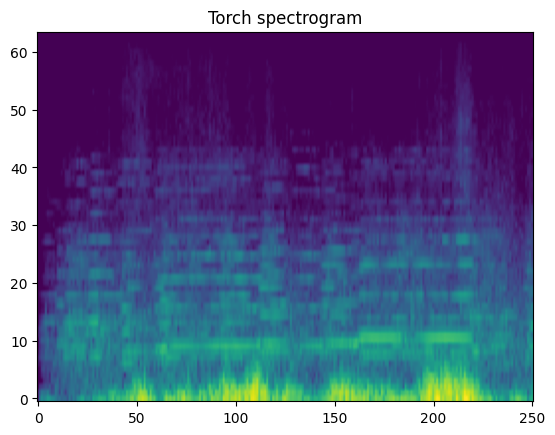

In [15]:
# See what the spectrogram looks like before padding and shifting

unshifted_spec = util.spectro_gram(resampled)
util.plot_spec(torch.squeeze(unshifted_spec[1:]))

In [16]:
shifted = util.time_shift(padded, 0.4)
print(shifted[0])

tensor([[0.0652, 0.0657, 0.0668,  ..., 0.0137, 0.0134, 0.0131],
        [0.0131, 0.0129, 0.0123,  ..., 0.0660, 0.0656, 0.0652]])


tensor([[[ 27.3923,  28.2360,  27.9847,  ...,  26.8318,  21.3966,  15.1648],
         [ 14.0806,  17.8062,  18.1172,  ...,  17.0039,  10.9477,   3.5047],
         [  9.2585,  -5.8842,  11.5981,  ...,  -0.1500,  -0.2805,  -4.0897],
         ...,
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288],
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288],
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288]],

        [[ 13.9619,  16.0901,  19.7670,  ...,  22.6290,  28.3426,  20.5344],
         [ -2.1705,  14.4869,  15.8217,  ...,   3.6222,  17.9070,  14.1380],
         [ -1.8897,   1.9384,  -0.4464,  ...,  -2.2452,   9.4507,  10.2432],
         ...,
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288],
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288],
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288]]]) torch.Size([2, 64, 313])


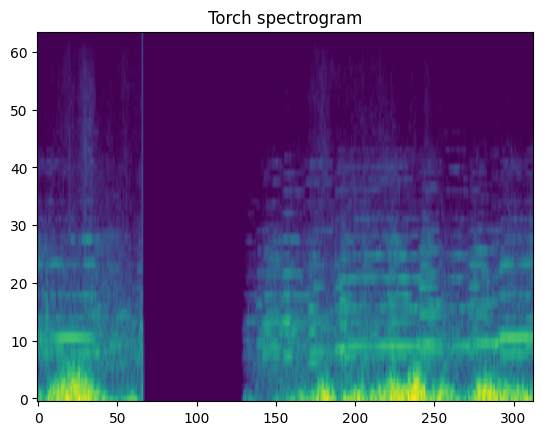

In [17]:
spec = util.spectro_gram(shifted)
print(spec, spec.shape)
util.plot_spec(torch.squeeze(spec[1:]))

tensor([[[-23.7445, -23.7445, -23.7445,  ..., -23.7445, -23.7445, -23.7445],
         [-23.7445, -23.7445, -23.7445,  ..., -23.7445, -23.7445, -23.7445],
         [-23.7445, -23.7445, -23.7445,  ..., -23.7445, -23.7445, -23.7445],
         ...,
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288],
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288],
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288]],

        [[-23.7445, -23.7445, -23.7445,  ..., -23.7445, -23.7445, -23.7445],
         [-23.7445, -23.7445, -23.7445,  ..., -23.7445, -23.7445, -23.7445],
         [-23.7445, -23.7445, -23.7445,  ..., -23.7445, -23.7445, -23.7445],
         ...,
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288],
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288],
         [-36.5288, -36.5288, -36.5288,  ..., -36.5288, -36.5288, -36.5288]]]) 
 torch.Size([2, 64, 313])


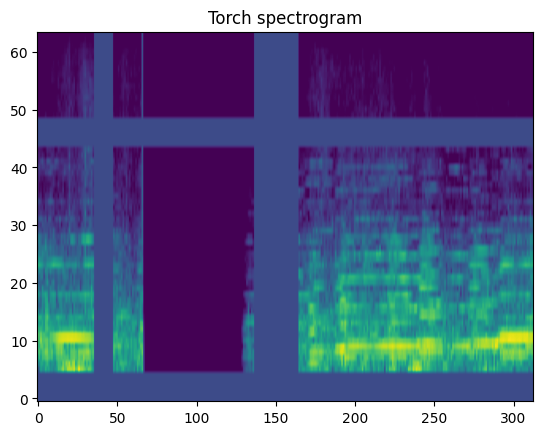

In [18]:
aug_spec = util.spectro_augment(spec, n_freq_masks=2, n_time_masks=2)

print(aug_spec, "\n", aug_spec.shape)
util.plot_spec(torch.squeeze(aug_spec[1:]))

In [19]:
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import numpy as np

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4

    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df)    

    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenate the audio directory with
        # the relative path
        # print({f"this is index {type(idx)}"})
        audio_file = self.data_path + self.df.loc[int(idx), 'relative_path']
        # Get the Class ID
        class_id = self.df.loc[int(idx), 'classID']

        aud = AudioUtil.open(audio_file)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So make all sounds have the same number of channels and same 
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)

        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id
    
    def get_folds(self):
        return torch.tensor(df.loc[:,'fold'])
    
    def get_x_and_y(self):
        data = [self.__getitem__(idx) for idx in range(self.__len__())]
        x = torch.stack([item[0] for item in data])
        y = torch.tensor([item[1] for item in data])
        del data
        return x, y
        

In [20]:
# from sklearn.model_selection import LeaveOneGroupOut

# Create dataset
myds = SoundDS(df, download_path)

# # Create the data split by the given fold
# splits = LeaveOneGroupOut()
# n_splits = splits.get_n_splits(groups=myds.get_folds())


In [21]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [22]:
torch.cuda.is_available()

True

In [23]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, dataset, num_epochs):
    # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    
    #x, y = dataset.get_x_and_y()
    
    val_accuracies = []
    
    folds = dataset.get_folds()
    folds = folds.to(device)
    
    # Repeat for each epoch
    for epoch in range(num_epochs):
        
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        correct_val_prediction = 0
        total_val_prediction = 0
        
        
        
        for fold in range(1, 11):
        #for fold, (train_idx, val_idx) in enumerate(splits.split(x, y, groups=dataset.get_folds())):

            print(f'Fold {fold}')
            
            train_idx = torch.where(folds != fold)[0]
            val_idx = torch.where(folds == fold)[0]
            
            
            #train_idx, val_idx = train_idx.to(device), val_idx.to(device)
            
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001 if fold < 5 else 0.0001)
            train_sampler = SubsetRandomSampler(train_idx)
            val_sampler = SubsetRandomSampler(val_idx)
            train_dl = DataLoader(dataset, batch_size=16, sampler = train_sampler, drop_last=True)
            val_dl = DataLoader(dataset, batch_size=16, sampler=val_sampler, drop_last=True)

            #val_acc_per_fold = []
        
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                            #steps_per_epoch=int(len(train_dl)),
                                            #epochs=num_epochs,
                                            #anneal_strategy='linear')


            # Repeat for each batch in the training set
            for i, data in enumerate(train_dl):
                # Get the input features and target labels, and put them on the GPU
                inputs, labels = data[0].to(device), data[1].to(device)

                # Normalize the inputs
                inputs_m, inputs_s = inputs.mean(), inputs.std()
                inputs = (inputs - inputs_m) / inputs_s

                # Zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                #scheduler.step()

                # Keep stats for Loss and Accuracy
                running_loss += loss.item()

                # Get the predicted class with the highest score
                _, prediction = torch.max(outputs,1)
                # Count of predictions that matched the target label
                correct_prediction += (prediction == labels).sum().item()
                total_prediction += prediction.shape[0]
                
                model.eval()
                
            for i, data in enumerate(val_dl):
                inputs, labels = data[0].to(device), data[1].to(device)

                # Normalize the inputs
                inputs_m, inputs_s = inputs.mean(), inputs.std()
                inputs = (inputs - inputs_m) / inputs_s

                # forward + backward + optimize
                outputs = model(inputs)
                _, prediction = torch.max(outputs,1)
                # Count of predictions that matched the target label
                correct_val_prediction += (prediction == labels).sum().item()
                total_val_prediction += prediction.shape[0]
                
                
                
            val_acc_per_fold = correct_val_prediction / total_val_prediction
            print(f'Validation accuracy for fold {fold}: {val_acc_per_fold:.2f}')
            #val_accuracies.append(val_acc_per_fold)
            #avg_val_acc = sum(val_accuracies) / n_splits
                
                

                #if i % 10 == 0:    # print every 10 mini-batches
                #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

            # Print stats at the end of the epoch
        num_batches = len(train_dl) * 10
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        val_acc = correct_val_prediction/total_val_prediction
        val_accuracies.append(val_acc)



        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}, Val Accuracy: {val_acc:.2f}')
        
        
        
    print(f'Finished Training. Average validation accuracy: {sum(val_accuracies)/len(val_accuracies):.2f}')


In [24]:
num_epochs=2 
training(myModel, myds, num_epochs)

Fold 1
Validation accuracy for fold 1: 0.36
Fold 2
Validation accuracy for fold 2: 0.40
Fold 3
Validation accuracy for fold 3: 0.44
Fold 4
Validation accuracy for fold 4: 0.47
Fold 5
Validation accuracy for fold 5: 0.51
Fold 6
Validation accuracy for fold 6: 0.53
Fold 7
Validation accuracy for fold 7: 0.55
Fold 8
Validation accuracy for fold 8: 0.57
Fold 9
Validation accuracy for fold 9: 0.58
Fold 10
Validation accuracy for fold 10: 0.59
Epoch: 0, Loss: 1.13, Accuracy: 0.61, Val Accuracy: 0.59
Fold 1
Validation accuracy for fold 1: 0.67
Fold 2
Validation accuracy for fold 2: 0.66
Fold 3
Validation accuracy for fold 3: 0.65
Fold 4
Validation accuracy for fold 4: 0.65
Fold 5
Validation accuracy for fold 5: 0.67
Fold 6
Validation accuracy for fold 6: 0.69
Fold 7
Validation accuracy for fold 7: 0.70
Fold 8
Validation accuracy for fold 8: 0.71
Fold 9
Validation accuracy for fold 9: 0.72
Fold 10
Validation accuracy for fold 10: 0.72
Epoch: 1, Loss: 0.75, Accuracy: 0.75, Val Accuracy: 0.72
Fi

In [25]:
myds[6244]

(tensor([[[ 43.0111,  45.6073,  29.4856,  ...,  24.0505,  28.7594,  40.1291],
          [ 35.8189,  45.7462,  27.4431,  ...,  25.6078,  30.7279,  34.6534],
          [ 32.1900,  41.3663,  26.7662,  ...,  31.1150,  31.2726,  25.3806],
          ...,
          [-29.0112,   1.5505,  -0.4256,  ..., -31.2860, -31.2860, -31.2860],
          [-28.2149,   1.6039,  -0.3757,  ..., -31.2860, -31.2860, -31.2860],
          [-28.3017,   1.7400,  -0.2386,  ..., -31.2860, -31.2860, -31.2860]],
 
         [[ 26.8846,  34.9715,  16.9778,  ...,  39.5756,  37.0787,  35.5844],
          [ 27.5038,  29.9057,  11.2269,  ...,  38.5657,  34.9116,  33.0456],
          [ 29.1345,  27.7383,  18.2913,  ...,  31.0335,  31.9188,  34.5044],
          ...,
          [-30.4845, -16.0881, -17.9792,  ..., -31.2860, -31.2860, -31.2860],
          [-29.2059, -15.7965, -17.7605,  ..., -31.2860, -31.2860, -31.2860],
          [-29.1719, -15.7978, -17.7699,  ..., -31.2860, -31.2860, -31.2860]]]),
 9)

In [26]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, inputs):
    
    inputs = inputs.to(device)

    # Disable gradient updates
    with torch.no_grad():

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s
        
        model.eval()

        # Get predictions
        outputs = model(inputs)

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)

    return prediction

In [27]:
# Run inference on trained model with a random item from the dataset
idx = random.randint(0, len(myds))
print(f"Predicted class: {int(inference(myModel, torch.unsqueeze(myds[idx][0], 0)))}")
print(f"Actual class: {myds[idx][1]}")


Predicted class: 8
Actual class: 8


In [28]:
print(len(myds[0]))

2
